In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import re

import seaborn as sns
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/kaggle/input/password-strength-classifier-dataset/data.csv', error_bad_lines=False)
df = df.dropna()

In [ ]:
df.head()

# Feature Generation
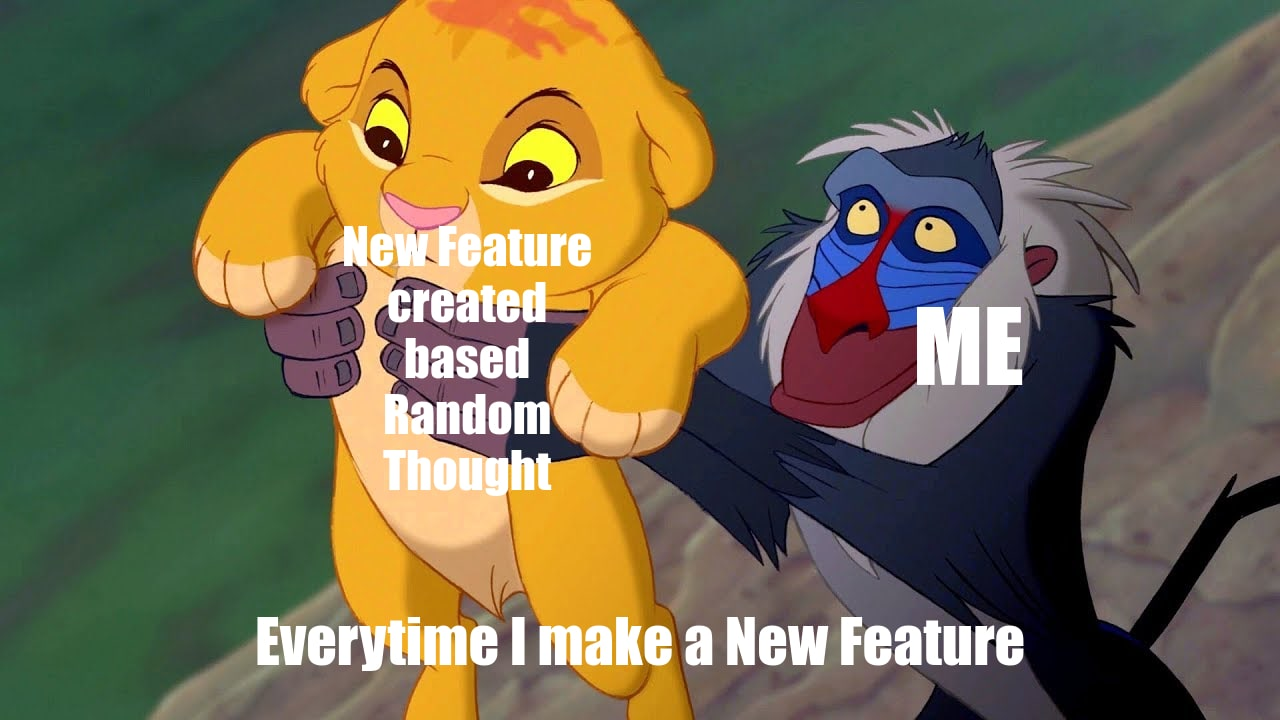

Whenever I see a data I don't magically expect the features to get generated on their own or randomly pop up in my mind. The first step I take to generate new features is to understand the factors target variable depends on. Now in this case, we have password strength so you can do a quick google search to check what features password depends on:-

* Length of password
* Frequency of Lowercase Characters
* Frequency of Uppercase Characters
* Frequency of Numeric Characters
* Frequency of Special Characters

These will be the result of the google search to find factors effecting strength of password. But thing to understand is won't it be more insightful to check the frequency of characters with respect to length? I length is long frequency will be high but you can instead measure a proportion to get an idea about the distribution of the characters in the password.

In [ ]:
# Adding column for length of Password 
df['length'] = [len(i) for i in df['password']]

# Adding column for ratio lowercase character in password
df['lower_freq'] = [len([j for j in i if j.islower()]) / len(i) for i in df['password']]

# Adding column for ratio uppercase character in password
df['upper_freq'] = [len([j for j in i if j.isupper()]) / len(i) for i in df['password']]

# Adding column for ratio numeric character in password
df['digit_freq'] = [len([j for j in i if j.isdigit()]) / len(i) for i in df['password']]

# Adding column for ratio special character in password
df['special_freq'] = [len([j for j in i if not j.isdigit() and not j.isalpha()]) / len(i) for i in df['password']]

If you search a bit more into the factors affecting you'll find 2 feature that affect the strength of password are:-

* Consecutive Sequence i.e. abc, 123 etc.
* Identical Sequences i.e. aaaa, bbb, etc.

Let's create a column that tells if there is a identical sequence or not.

In [ ]:
# Adding column for telling if a column has identical features
df['identical_freq'] = [(re.match('([a-z\\d])\\1\\1\\1\\1\\1\\1\\1+', i) is not None) for i in df['password']]

In [ ]:
chi2(df['identical_freq'].values.reshape(-1, 1), df['strength'].values)

Hmm, that's an chi2 stats with value 5.91 for a p-value of 0.052. For those who don't understand it I'm saying that the feature **identical_freq** and target variable are dependent on each other. How can I say that? Well in any test if we take the usual significance level of 0.05 then,

* **p-value < 0.05:** Reject Null Hypothesis for Alternative Hypothesis
* **p-value >= 0.05:** Fail to reject the Null Hypothesis

Since value the p value we got is more than 0.05 we can reject the Null Hypothesis for Alternative Hypothesis of chi square that says that **"Both Variables are dependent"**. Weather this is useful or not we'll check soon.

**How did I come up with that particular feature?**

It wasn't a rocket science I knew that identical sequences affect the strength of password so I found the regex to match the identical sequence with repetition of 2 or more but the p-values were very very low, I talking somewhere around 1e-238. Yea I know xD. My intial response was to dump it but then I thought *what if I increase the threshold of repetition?*. I tried for 3,4,5,6.. until the df gave all False. I noted chi2 of all and found that  for repetition of 7 or more the p value was more than 0.05 so I set that as threshold and created that feature. Weather this feature is useful or not will be tested via Random Forest Feature Importance or other methods and at that time it's fate will be decide.

> To be or not to be? Is the question.

In [ ]:
df['type_breaks'] = [len(re.findall('[aA-zZ]+',i)) + len(re.findall('[\W]+', i)) + len(re.findall('[0-9]+', i)) - 1 for i in df['password']]

Now this is one of the things that randomly poped up in my mind after learning about the above 2 features is that password is not just depending on the characters in it but also the ordering so I thought that maybe it depends on the no. of groups two like how mixed up these character groups are. For eg, abc12 is not so good but a1b2c is better. How am I sure? See for yourself.

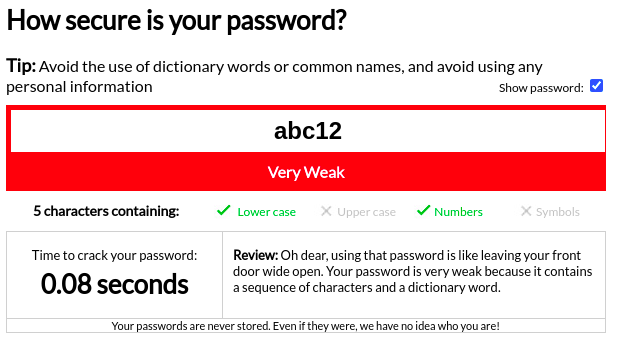
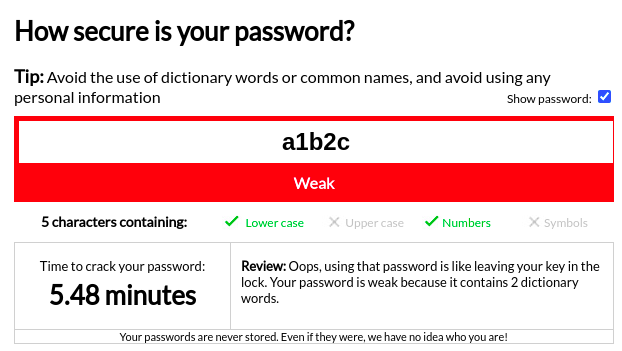

Credits: https://www.my1login.com/resources/password-strength-test/

That's why I wrote a regex to find all the groups and added the no. of the groups to create the feature **type_breaks**.

So what happens when you are out of ideas? Simple Answer!

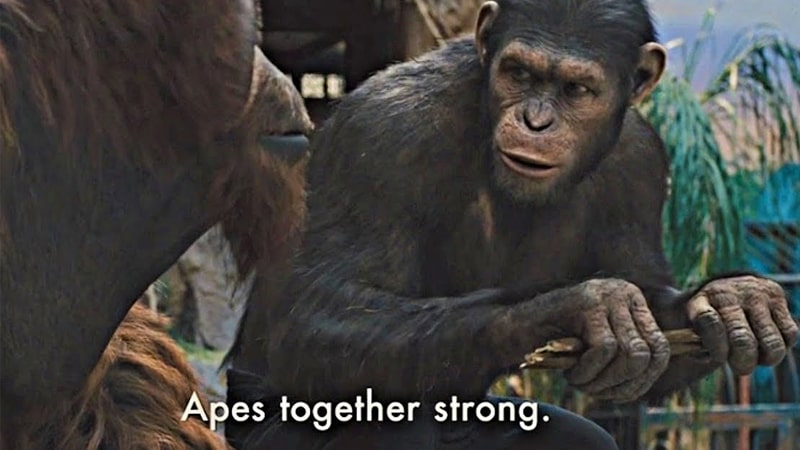

What I mean to say is when you are stuck take help, **checkout notebooks of other people, ask your mentor or google**. 

# **Exploratory Data Analysis**

EDA or Exploratory Data Analysis is a process of understanding the data often to give birth to new features or simply for the purpose to understand the behavior of various features. Now for me EDA and Feature Engineering go hand in hand I may have written the Feature Generation part before this but when working on feature generation I always vizualize and run tests on the generated feature to validate it and add to the feature matrix. 

When I was getting started with EDA I had no idea how to proceed or what to do? But steady as I accustomed myself with Basic Statistics I started to understand why we do it and what should we do. I you ask me EDA is all about asking questions to the data. What is your distribution? How to you behave w.r.t. another feature? There is no end to the list and there is no end to what you can find with EDA.

EDA is all about asking smart questions but to get started you can use the following pipeline(for categorical target):-

1. **Descriptive Statistics:** Reading Basic Summary Stats to get the vague idea about data distribution To Vizualize you can use Box-Plots, Violin Plots etc.
2. **Agrregated Descriptive Statistics:** Basic Summary Stats of Features when grouped w.r.t. target to understand the distribution of data among each class. This can make you understand how the values of the feature are distributed among target classes. Kinda like boxplot except outliers are included in calculation
3. **Univariate Analysis:** Understanding the distribution or class count of the features. The step 1 is a part of Univariate Analysis. Here you can visualize your distribution check out frequency of class in a feature getting basic layout of your features. Histogram, KDE, countplots etc. can be used to vizualize this.
4. **Bivariate Analysis:** Understanding the behavior of feature w.r.t. other feature(usually target). Now usually the combos and their corresponding plots are:-
      * **Continuous-Continuous:** Correlation among them can be told by pearson coefficient, you can vizualize that using Heatmaps. You can build scatter plots to vizualize how they move w.r.t. to each other. 
      * **Continuous-Categorical:** Finding how features are splitted over categorical features (I do it just with Target but depending on questions you want answer to you can try it among the features too). Box-Plot, Violin Plot, Strip Plot etc. can be used to vizualize this relationship.
      * **Categorical-Categorical:** This is the most interesting one, in order to understand if 2 categorical features(usually target being one of them) are dependent on each other you can try using chi-square. To vizualize you can use countplots with target variable as hue what you get from that is basically the same as step 2 so I often don't do it but plots are easier to explain so no reason not to.
5. **Multivariate Analysis:** Behavior of features w.r.t. multiple features. To vizualize this you can use Joint Plots, Pair Plots or scatter plots with categorical feature(usually target) as hue. 3d scatter plots are an option too but I find them hard to interpret so I avoid them.

That's a pipeline that you can follow to get started and given the data you can modify it and try other stuff too. Now one question you may ask is that if we have data from step 2 why should I vizualize it with box plots or whatever. Answer to that is **Anscombe's Quartet**. Anscombe's Quartet gives an important lesson i.e. numerical data can be misleading. There are many things you can't check in these Descriptive Stats like effect of outliers, high leverage points, etc. Hence, it is important to vizualize and the fact that graphs are easier to explain to people.

## **Descriptive Statistics**

In [ ]:
df.describe(include = 'all')

In [ ]:
plt.figure(figsize = (16,8))
ax1 = plt.subplot2grid((2, 3), (0, 0))
ax1 = sns.boxplot(x = 'length', data = df)

ax2 = plt.subplot2grid((2, 3), (0, 1))
ax2 = sns.boxplot(x = 'lower_freq', data = df)

ax3 = plt.subplot2grid((2, 3), (1, 0))
ax3 = sns.boxplot(x = 'digit_freq', data = df)

ax4 = plt.subplot2grid((2, 3), (1, 1))
ax4 = sns.boxplot(x = 'upper_freq', data = df[df['upper_freq'] > 0])

ax5 = plt.subplot2grid((2, 3), (0, 2))
ax5 = sns.boxplot(x = 'special_freq', data = df[df['special_freq'] > 0])

ax6 = plt.subplot2grid((2, 3), (1, 2))
ax6 = sns.boxplot(x = 'type_breaks', data = df[df['type_breaks'] > 0])

Outliers seem to be having fun don't they? From above plot and table you can get a general overview of distribution of the data in each feature. The outliers and the quartile range is there but do we get anything that would provide any insight the table wouldn't have? In my opinion no, the table pretty much told everything and that is why unless I plan showcase I don't usually go on plotting every plot I see. There are two type of approaches:-

* **Plotting for the sake of Plotting:** Lots of Plot but Less on Info.
* **Plotting for the sake of extraction:** Apt amount of plot but each plot serves a putpose.

Be the better person.

## **Agrregated Descriptive Statistics**

In [ ]:
from IPython.display import display

cols = ['length', 'lower_freq', 'upper_freq', 'digit_freq', 'special_freq']

for i in cols:
    print(i)
    display(df[df[i] > 0].groupby('strength')[i].agg(['max', 'min', 'mean', 'median', pd.Series.mode]))

Just taking a rough look at the above data I can say the following:-
* Higher the length, Higher the strength
* In case on alphabet frequency higher is not better. Probably because it'll not be a strong password if max portion is occupied by just alphabets.
* Password has more strength if the char types are spread in decent proportions.

## **Univariate Analysis**

### **Checking Class Imbalance**

In [ ]:
sns.countplot(x = 'strength', data = df)
plt.plot()

print(df['strength'].value_counts(),'\n\n\n')

Wow that's quite a bit of imbalance among the target classes but thing to know it was purpose does knowing or checking imbalance solve for us? Thing is class imbalance affects the model performance quite a bit so if you try to train the model without tackling this issue you might end up getting a model that's biased towards the majority class so you need to tackle the issue accordingly and hence it becomes important not only to check imbalance but also to know how much imbalance is there.

### **Continuous Variables**

In [ ]:
plt.figure(figsize = (16,16))
ax1 = plt.subplot2grid((3, 3), (0, 0))
ax1 = sns.histplot(x = 'length', data = df, bins=50)

ax2 = plt.subplot2grid((3, 3), (0, 1))
ax2 = sns.histplot(x = 'lower_freq', data = df)

ax3 = plt.subplot2grid((3, 3), (1, 0))
ax3 = sns.histplot(x = 'digit_freq', data = df)

ax4 = plt.subplot2grid((3, 3), (1, 1))
ax4 = sns.histplot(x = 'upper_freq', data = df[df['upper_freq'] > 0])

ax5 = plt.subplot2grid((3, 3), (0, 2))
ax5 = sns.histplot(x = 'special_freq', data = df[df['special_freq'] > 0])

ax6 = plt.subplot2grid((3, 3), (1, 2))
ax6 = sns.histplot(x = df[df['special_freq'] > 0]['special_freq'].apply(np.log))  # Log Transformation

ax7 = plt.subplot2grid((3, 3), (2, 0), colspan = 3)
ax7 = sns.histplot(x = 'type_breaks', data = df, bins=50)

I usually go for histograms when doing univariate analysis now here you can get the idea about:-
* **Skewness of Data:** Once you know this you can apply various transformations and use the one that gives the best results. Tackling skewness is important cuz many statistical models(like linear regression) and test work on the assumption of normally distributed data. But Skewness doesn't effect tree based models so based on the task you can decide if you need to tranform it to normal distribution or not.
* **Data Distribution:** Tells you what bins are of higher range or lower range one example is if you are doing a customer base analysis you can check what age range most customer belongs too or a more common example is if you have text data you can plot length histograms and check the suitable max_length to pad or truncate.

You can see the (2,3)th plot shows special_freq data after log tranformation I tried square root and cube root transformation too and visualized them but log came to be the best so chose that. This is one of many uses of histograms.

### **Categorical Variables**

In [ ]:
sns.countplot(x = 'identical_freq', data = df)
plt.plot()

print(df['identical_freq'].value_counts(),'\n\n\n')

Phew! That amount of split only gets one verdict from my side i.e. DELETE DELETE DELETE. This is why it becomes important to check frequency of categorical variable not just to check no. of class but also how they are distributed and in these only you can ask various questions and get their answers.

## **Bivariate Analysis**

### **Continous-Continuous**

In [ ]:
plt.figure(figsize = (10, 8))
sns.heatmap(df.corr(), annot = True)
plt.plot()

* Length and Strength show high correlation not much of a surprise there.
* identical_freq is least correlated to strength, probably gonna get removed.
* lower_freq, upper_freq and type_breaks are a bit correlated to strength.

You can go ahead add a pair-pair plot or something else but I got the answers to most of the questions from this so not going forward. But that doesn't mean there isn't anything more. Different Situation require different EDA.

### **Categorical-Continous**

In [ ]:
plt.figure(figsize = (20,12))
ax1 = plt.subplot2grid((2, 4), (0, 0))
ax1 = sns.boxplot(x = df['strength'], y = df['length'], showfliers = False)   # showfliers = False doesn't plot outliers, too messy to infer anything so switched off.

ax2 = plt.subplot2grid((2, 4), (0, 1))
ax2 = sns.boxplot(x = 'strength', y = 'lower_freq', data = df[df['lower_freq'] > 0])

ax3 = plt.subplot2grid((2, 4), (1, 0))
ax3 = sns.boxplot(x = 'strength', y = 'upper_freq', data = df[df['upper_freq'] > 0])

ax4 = plt.subplot2grid((2, 4), (1, 1))
ax4 = sns.boxplot(x = 'strength', y = 'digit_freq', data = df[df['digit_freq'] > 0])

ax5 = plt.subplot2grid((2, 4), (0, 2))
ax5 = sns.boxplot(x = 'strength', y = 'special_freq', data = df[df['special_freq'] > 0])

ax6 = plt.subplot2grid((2, 4), (1, 2))
ax6 = sns.boxplot(x = 'strength', y = 'type_breaks', data = df[df['type_breaks'] > 0])

ax7 = plt.subplot2grid((2, 4), (0, 3), rowspan = 2)
ax7 = sns.boxplot(x = df['strength'], y = df['length'])
ax7 = plt.ylim(0,70)

Although I don't have much favorites when it comes plots, whatever gets the job done is fine, but if I had one Boxplot would be it. I mean the amount of information that single plot conveys is mind blowing. You get info about outliers, quartiles, median well technically 2nd quartile is median but you get the gist. Now these stuff can bee seen without boxplot but by visualizing them you can clearly check out the trend and splits if any and better interpret. Plotting is a part of pipeline but it's not the pipeline itself. 

Regarding the insights we can say that:-
* We can say that strength can be solely determined based on length since it gives a perfect split. That would be the best feature then but logically that doesn't sound correct because when I ran 2 password of same length over checker they gave 2 different level. Now I understand the logic they use is different and for this data length is the best but of larger scale things might be iffy. But yes longer passwords have more strength so given the circumstance we might even just use length based classification or use it as primary feature.

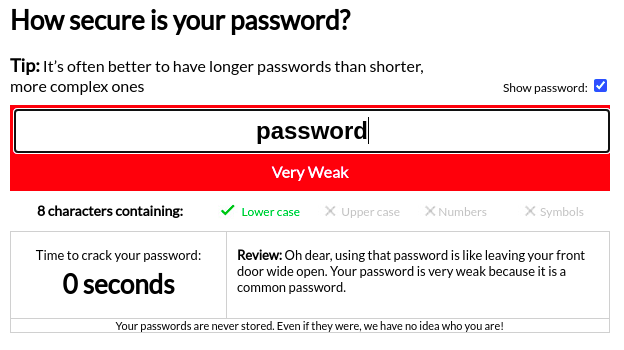
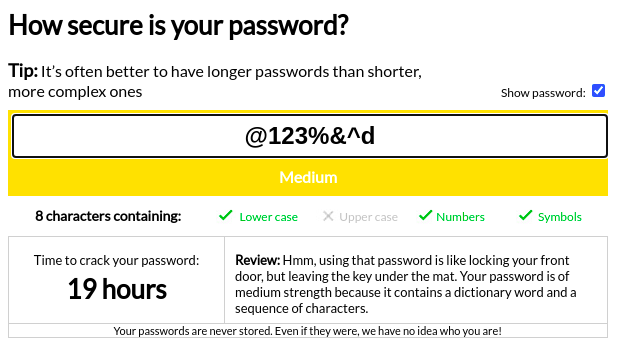

* Higher Lowercase frequency is seen in low strength passwords. For higher strength passwords that can be high too but that is probably effect of length.
* In upper_freq there is a trend but not as strong as length or lower_freq.
* In digit_freq there is a split of majority poplutation of strength 1 and 2 but for 0 and 1 strength there is overlap so no tmuch to say there. But we can say a nicely propotioned password is good.
* Similar but stronger same trend as above in special_freq.
* Higher strength passwords have more type breaks.

### **Categorical-Categorical**

In [ ]:
chi2(df['identical_freq'].values.reshape(-1, 1), df['strength'].values)

I know I did this above but this is just to explain. Try doing chi2 for categorical columns to check for independancy. Usually I do this when I have categorical target but give the situation you can try it among feature. Remember kaggle and real life analysis are different.

You can also try hued count plots but in this case **True** data is so less we won't get any proper insights and if you aren't getting insights there is no point plotting it.

## **Multivariate Analysis**

In [ ]:
plt.figure(figsize = (24,16))
cols = ['length', 'lower_freq', 'upper_freq', 'digit_freq', 'special_freq', 'type_breaks']
m, n = 0, 0
s = set()

for i in cols:
    for j in cols:
        if (i, j) in s or (j, i) in s or i == j:
            continue
        
        ax = plt.subplot2grid((3, 5), (m, n))
        ax = sns.scatterplot(x = i, y = j, hue = 'strength', data = df)
        s.add((i, j))
        
        n += 1
        if n == 5:
            n = 0
            m += 1
plt.plot()

Here you take a look at how multiple feature collectively behave check if there is any clusters being formed or range dependant class distribution being followed. Depending on tasks you can check many things but these are the basic ones you should be looking at.